<a href="https://colab.research.google.com/github/rcurrie/notebooks/blob/master/entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import requests
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

import html
from IPython.core.display import display, HTML

def printhtml(html):
    display(HTML(html))

In [0]:
base_url = "https://s3.nautilus.optiputer.net/braingeneers/archive/derived"

def load_sample(guid, name):
    """ 
    Load signal and metadata stored in S3 via the ingest notebook. 
    Returns a dictionary with metadata and signal:
    X = signal vector of microvolt time series readings, one for each of the channels
    t = time in milliseconds for each reading (for conveniance, all samples at fs)
    fs = sample rate
    experiment = experiment metadata ie notes, operator, github issue id
    """
    sample = requests.get("{}/{}/{}.json".format(base_url, guid, name)).json()
    sample["experiment"] = requests.get("{}/{}/metadata.json".format(base_url, guid)).json()
    sample["fs"] = sample["frequency_parameters"]["amplifier_sample_rate"]
    with np.DataSource(None).open("{}/{}/{}.npy".format(base_url, guid, name), "rb") as f:
        X = np.load(f)
    # Convert from 16 bit uint to floating point microvolts array as per Intam sample code
    sample["X"] = np.multiply(0.195, (X.astype(np.int32) - 32768))
    sample["t"] = np.linspace(0, 1000 * sample["X"].shape[1] / sample["fs"], sample["X"].shape[1])   
    return sample

## Baseline

In [3]:
baseline = load_sample("2019-01-22", "256A2_test_190122_112728")

for key, value in baseline["experiment"].items():
    printhtml("<b>{}: </b>{}".format(html.escape(key), html.escape(value)))

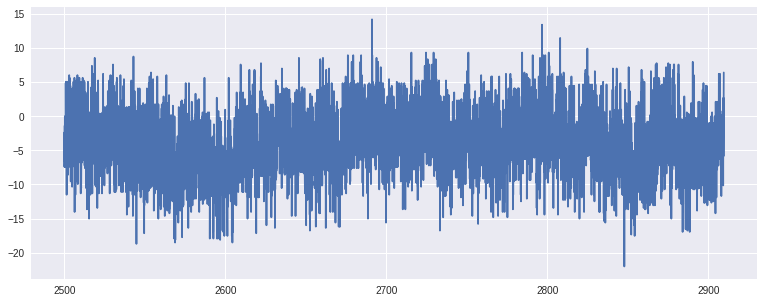

In [4]:
start = 50000
plt.figure(figsize=(13,5))
plt.plot(baseline["t"][start:start+8192], baseline["X"][0][start:start+8192])
plt.show()

## Signal

In [5]:
# There are multiple .npy as the recording was over a long time, use one for now
signal = load_sample("2018-12-14", "R_UCSC355A_64D26_181214_132446")

for key, value in signal["experiment"].items():
    printhtml("<b>{}: </b>{}".format(html.escape(key), html.escape(value)))

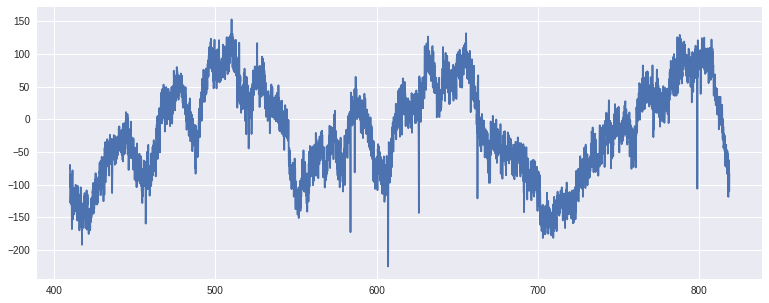

In [6]:
start = 8192
plt.figure(figsize=(13,5))
plt.plot(signal["t"][start:start+8192], signal["X"][0][start:start+8192])
plt.show()

In [7]:
!pip install --user PyWavelets
import pywt

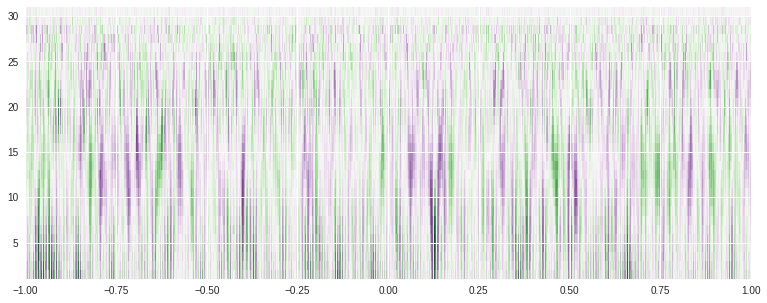

In [8]:
start = 50000
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(baseline["X"][0][start:start+8192], widths, 'morl')

plt.figure(figsize=(13,5))
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  
plt.show() 

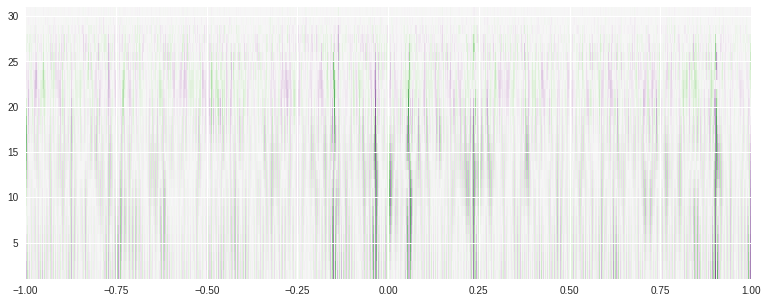

In [9]:
start = 8192
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(signal["X"][0][start:start+8192], widths, 'morl')

plt.figure(figsize=(13,5))
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  
plt.show() 